#Per esecuzione
caricare cartella utils con 9 documenti


1.   it.test.data.txt
2.   my-data-bushajaldo.txt
3.   my-data-bushajantonino.txt
4.   my-data-frisullo.txt
5.   mini_NASARI.tsv
6.   SemEval17_IT_senses2synsets.txt
7.   annotazione1/2/3.txt




**Consegna 1:**
    La prima consegna dell'esercizio prevede il calcolo degli indici di correlazione di Pearson e Spearman come inter-rate agreement tra le annotazioni fatte a mano per ogni coppia di parole dai singoli componenti del gruppo.
    La valutazione delle annotazioni sarà effettuata in correlazione con i vettori NASARI(versione embedded), questi vettori saranno utilizzati andando a massimizzare la cosine similarity. A questo punto si calcola la correlazione fra la media dei punteggi annotati a mano da noi e quelli calcolati con la versione embedded di NASARI, facendo una media tra i due
    I termini che non hanno il corrispettivo vettore NASARI vengono esclusi dalla valutazione

**Consegna 2:**
    Vengono annotati a mano i sensi selezionati nel giudizio di similarità scrivendo, per ogni coppia, i babel synset id. Si calcola così la correlazione tra le due annotazioni utilizzando il punteggio kappa di Cohen.
    Poi si utilizzano nuovamente i vettori NASARI (versione densa, embedded) per calcolare la coppia di sensi che
    massimizzano lo score di similarità.
    Misuriamo infine l’accuratezza tra annotazioni manuali e calcoli automatici sia sui singoli elementi, sia sulle coppie.

OUTPUT/RISULTATI DEL PROGRAMMA:

    Inter-rate agreement on annotated similarity scores: Pearson: 0.209206361104891 - Spearman: 0.9148486673171229


    Correlation human - algorithm on similarity scores: Pearson: 0.6493589855181132 - Spearman: 0.5764922979004797


    Inter-rate agreement on annotated senses: Cohen's Kappa: 0.8981670061099796
    
    
    Accuracy between annotated and calculated senses: Single elements: 63.0% - Couples: 32.0%


**Esempio output:**

Term1 Term2 BS1 BS2 Terms_in_BS1 Terms_in_BS2

macchina bicicletta bn:00007309n bn:00010248n

auto,automobile,macchina bicicletta,bici,bike

COMMENTO SULL'OUTPUT:
    L'agreement tra gli annotatori è piuttosto alta: si può ben vedere che gli indici di correlazione sono alti
    tra i punteggi di similarità e i sensi intesi durante l'annotazione.
    Seppur molto alta, ad ogni modo, non si può effettivamente dire che ci sia una concordanza proprio totale.
    Tra le annotazioni e i risultati calcolati con la cosine similarity sembrano esserci, invece, delle discrepanze.
    Questo perché molto spesso, la coppia di sensi che massimizzano lo score di similarità del coseno, è molto affine
    a quella annotata, ma comunque diversa.
    Ad es. l'algoritmo sceglie come synset appropriato per 'protestante' in (protestante, cristiano) il synset che si
    riferisce al Protestantesimo come religione, anziché il senso inteso dagli annotatori di protestante come
    praticante della religione del Protestantesimo.


#Import necessari

In [10]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics import cohen_kappa_score
from numpy import inner
from numpy.linalg import norm
# from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import sklearn
import pprint

pp = pprint.PrettyPrinter(indent=4)

# Funzioni utili alla lettura dei dati

In [11]:
"""
    Leggiamo le annotazioni dal file_path e ritorniamo una lista, con tutte le
    annotazioni date dai singoli componenti del gruppo (abbiamo un file per ogni componente del gruppo)

    Es. annotazioni [((word1, word2), score)]:
      imperatore	costituzione	0.6
      matematico	spettacolo	0.2
      entropia	informazione	3

"""
def read_annotation(file_path):
    annotations = []
    file = open(file_path, "r", encoding='utf-8')
    for line in file:
        fields = line.strip().split('\t')
        if len(fields) == 3:
            word1 = fields[0].strip()
            word2 = fields[1].strip()
            score = float(fields[2].strip())
            annotations.append(((word1, word2), score))

    return annotations


# Leggiamo dal file tsv le coppie di cui annoteremo le similarità
def read_coppie(file_path):
    res = []

    file = open(file_path, "r")
    for line in file:
        s = line.split("\t")
        res.append((s[0].lower().strip(), s[1].lower().strip()))
    file.close()
    return res


# Lettura del mapping tra termine e babelsynset
# Risultato del Mapping :
# {
#   'termine' : {babelsynset1, babelsynset2 ...}
# }
def read_mapping_senses_to_synsets(coppie, file_path):
    res = {}
    termine = ""

    file = open(file_path, "r")
    # Lettura riga per riga del file del mapping
    for line in file:
        line = line.strip()
        # Verifichiamo che la riga corrente non è vuota ed è > 0
        if (line is not None) and (len(line) > 0):
            # Se la riga inizia con '#', e' il nome del termine
            # ES: #scheda madre     a seguire tutti i relativi babelsynsetid
            #     bn:00023437n
            if line.startswith('#'):
                # Si cerca se il termine fa parte di una delle coppie
                # con la funzione lambda ci assicuriamo, con "line[1:]", che escludendo la prima lettera (#)
                # abbiamo almeno un carattere.
                # Filter invece mi permette di filtrare le parole contenute in "coppie" per cui lambda
                # ha restituito true
                # ES: Result -> [('servo', 'schiavo')]
                result = list(filter(lambda x: x.count(line[1:].lower().strip()) > 0, coppie))
                if len(result) > 0:
                    # Memorizzo il termine senza #
                    termine = line[1:].lower().strip()
                    # Aggiungo al dizionario res la chiave "termine" con valore = lista vuota
                    res[termine] = []
                else:
                    termine = ""
            # se invece line non inzia con # allora è un babelsynset
            else:
                # quindi lo aggiungo al vettore del termine
                if termine != "":
                    res[termine].append(line.strip())
    return res

# Ricerca del termine dal valore del suo babelsynset, dove "values" è un dizionario
# mentre "searchFor" è il valore da cercare
def search(values, searchFor):
    for k in values:  
        for v in values[k]:
            if searchFor in v:
                return k
    return None

# Lettura vettore nasari

In [12]:
# Lettura nasari vector per ogni termine
# Return :
# {
#      {
#       'termine': ( [vettore nasari], 'babelsynset')
#      }
# }
def load_nasari_vectors(mapping_senses_to_synsets, file_path):
    nasari = {}
    file = open(file_path, "r", encoding='utf-8')

    # Lettura NASARI
    for line in file:
        line = line.strip()
        if (line is not None) and (len(line) > 0):
            # bn:00023437n__CPU_card	-0.06913958	-0.06749106	0.00770207......
            # con questo split avrò s= [bn:00023437n__CPU_card,-0.06913958,-0.06749106,....]
            s = line.split("\t")

            # Si cerca usando il babelsynsetId (letto nel file del mapping) se il concetto di nasari 
            # che si sta leggendo fa parte delle coppie
            # mapping_senses_to_synsets è un dizionario mentre il secondo parametro è il termine da cercare
            # quindi con questo split divido bn:00023437n__CPU_card, e quindi prendo il primo elemento 
            # che sarebbe il babelsynset bn:00023437n
            findKey = search(mapping_senses_to_synsets, s[0].split("__")[0].strip())
            if findKey != None:
                # se la chiava non è già presente in nasari la aggiungo
                if findKey not in nasari:
                    nasari[findKey] = []

                array = []
                # per ogni valore numerico della lista s
                for val in s[1:]:
                    # aggiungo il valore all'array 
                    array.append(val)
                # quindi nel dizionario "nasari" avrò con la chiave "findKey" tutti i valori numerici contenuti in
                # "array" e il relativo babelsynsetid
                nasari[findKey].append((array, s[0].split("__")[0].strip()))
    #pp.pprint(nasari)
    ''' ES: nasari= 'ban ki-moon': [([    '0.06689566',
                                          '0.01247473',
                                          '0.00811783'],
                                      'bn:02565886n'),...] '''
    return nasari

# Cosine Similarity
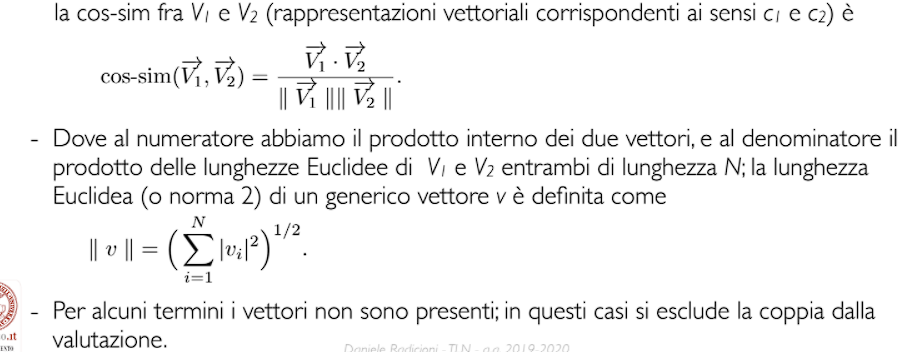

In [13]:
# Calcolo della cosine similarity per tutte le coppie, viene usata questa invece della semplice sim(c1, c2)
# Return :
# {
#     1: {'cosine': 4.170075589731172, 'coppia': ('cricket', 'sostenitore'), 'babelsynsets' : ('bn:00023796n', 'bn:01317296n')},
#     2: {'cosine': 1.0281868381155448, 'coppia': ('scultura', 'statua'), 'babelsynsets' : ('bn:00069924n', 'bn:00074064n')}
# }
def cosine_similarity(coppie, mapping, nasari):
    res = {}
    n = 1

    # Per ogni coppia
    for (a, b) in coppie:
        # Se entrambi i concetti hanno i vettori NASARI
        if a in nasari and b in nasari:
            # Prendo i vettori
            array1 = nasari[a]
            array2 = nasari[b]

            max_cosine = 0  # Valore max tra tutti i vettori dei 2 termini
            best_babelsynset_a = ""
            best_babelsynset_b = ""
            # Per ogni tupla 'termine' :(lista di valori, babelsynsetid) del termine 1 in nasari
            for (v1, bs1) in array1:
                # Per ogni tupla 'termine' :(lista di valori, babelsynsetid) del termine 2
                for (v2, bs2) in array2:
                    # calcoliamo la cosine similarity con la funzione di libreria
                    cosine = sklearn.metrics.pairwise.cosine_similarity(np.array(v1).reshape(1, len(v1)),
                                                                        np.array(v2).reshape(1, len(v2)))[0][0]
                    
                    # quindi prendiamo la cosine similarity più grande trovata
                    if cosine > max_cosine:
                        max_cosine = cosine
                        best_babelsynset_a = bs1
                        best_babelsynset_b = bs2
            
            # inizializzo opportunamente il dizionario "res" 
            res[n] = {
                'coppia': (a, b),
                'babelsynsets': (best_babelsynset_a, best_babelsynset_b),
                'cosine': max_cosine
            }
            n += 1
    # pp.pprint(res)
    return res

#Calcoliamo l’agreement fra gli annotatori.

In [14]:
# Calcola i valori di correlazione di pearson e spearman tra la media dei valori annotati a mano
# e quelli calcolati automaticamente dall'algoritmo che usa la similarità del coseno
# human_ann1, human_ann2, human_ann3 annotazioni con coppie di parole e relativa similarità 
# per ogni componente del gruppo, algorithm_ann valore della cosine similarity
def correlation_human_algorithm(human_ann1, human_ann2, human_ann3, algorithm_ann):
    alfa = 4
    average_scores_human = []
    cosine_scores = []
    for i in range(len(human_ann1)):
        ''' Annotation[0] :(('cricket', 'sostenitore'), 0.7)
            Annotation[0][0] :('cricket', 'sostenitore')
            Annotation[0][0][0] :cricket'''
        # parola presa dal primo documento annotato, nell'esempio "cricket"
        word1 = human_ann1[i][0][0]
        # parola presa dal primo documento annotato, nell'esempio "sostenitore"
        word2 = human_ann1[i][0][1]
        # valore preso dal primo documento annotato, nell'esempio 0.7
        value1 = human_ann1[i][1]
        # valore preso dal secondo documento annotato...
        value2 = human_ann2[i][1]
        # valore preso dal terzo documento annotato...
        value3 = human_ann3[i][1]
        # algorithm_ann= 
        #{'cosine': 4.170075589731172, 'coppia': ('cricket', 'sostenitore'), 'babelsynsets' : ('bn:00023796n', 'bn:01317296n')},
        for j in algorithm_ann:
            # j mi permette di iterare tra i vari dizionari
            if algorithm_ann[j]['coppia'] == (word1, word2):
                average_human = (value1 + value2 + value3) / 3
                average_scores_human.append(average_human)

                cos = algorithm_ann[j]['cosine']
                cosine_scores.append(cos * alfa)
                break

    correlation_pearson, p_value = pearsonr(average_scores_human, cosine_scores)
    correlation_spearman, p_value = spearmanr(average_scores_human, cosine_scores)

    return correlation_pearson, correlation_spearman

# Metodi utili per la seconda parte dell'esercizio

In [15]:
# Misura accuratezza tra annotazione e algoritmo, su singoli elementi e coppie
def correlation_senses(annotation_human, annotation_algorithm):
    accuracy_single = 0
    accuracy_couple = 0
    for ann_human in annotation_human:
        word1 = ann_human[0]
        word2 = ann_human[1]
        bs1_human = ann_human[2]
        bs2_human = ann_human[3]
        # con questo for itero fra gli elementi di "annotation_algorithm" 
        for j in annotation_algorithm:
            ann_algorithm = annotation_algorithm[j]
            if ann_algorithm['coppia'] == (word1, word2):
                bs1_algorithm = ann_algorithm['babelsynsets'][0]
                bs2_algorithm = ann_algorithm['babelsynsets'][1]

                # print(word1, word2, bs1_human, bs2_human, bs1_algorithm, bs2_algorithm)
                # l'accuracy in questo caso viene incrementata solo se i babelsysnet fatti dagli umani e dall'algoritmo corrispondono
                if bs1_human == bs1_algorithm:
                    accuracy_single += 1
                if bs2_human == bs2_algorithm:
                    accuracy_single += 1
                if bs1_human == bs1_algorithm and bs2_human == bs2_algorithm:
                    accuracy_couple += 1

                break
    # accuracy_single viene divisa per len(annotation_human) * 2 in quanto posso aumentare l'accuracy 2 volte, nel caso in cui bs1_human == bs1_algorithm
    # e nel caso in cui bs2_human == bs2_algorithm
    accuracy_single = accuracy_single / (len(annotation_human) * 2)
    # mentre accuracy_couple no in quanto l'accuracy viene aumentata solo una volta
    accuracy_couple = accuracy_couple / len(annotation_human)
    return accuracy_single, accuracy_couple

def read_annotated_senses(file_path):
    """
    legge le annotazioni fatte a mano sui babel synset
    :param file_path:
    :return: lista di annotazioni [(word1, word2, bs1, bs2, terms_in_bs1, terms_in_bs2)]
    """
    annotations = []
    file = open(file_path, "r", encoding='utf-8')

    # Lettura NASARI
    for line in file:
        line = line.strip()
        if (line is not None) and (len(line) > 0):
            fields = line.split('\t')
            word1 = fields[0]
            word2 = fields[1]
            bs1 = fields[2]
            bs2 = fields[3]
            terms_in_bs1 = [term.strip() for term in fields[4].split(',')]
            terms_in_bs2 = [term.strip() for term in fields[4].split(',')]
            annotations.append((word1, word2, bs1, bs2, terms_in_bs1, terms_in_bs2))

    return annotations

# Scrittura file per la consegna 1 : <parola1, parola2, valore annotatore1, valore annotatore2, valore annotatore3, media valori>
def write_consegna1_file(human_ann1, human_ann2, human_ann3):
    f = open('utils/my-data-consegna1.txt', 'w')
    for i in range(len(human_ann1)):
        word1 = human_ann1[i][0][0]
        word2 = human_ann1[i][0][1]
        value1 = human_ann1[i][1]
        value2 = human_ann2[i][1]
        value3 = human_ann3[i][1]
        average_human = (value1 + value2 + value3) / 3
        f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(word1, word2, value1, value2, value3, average_human))

    f.close()

# Main, consegna 1

In [16]:
if __name__ == '__main__':

    ##### Consegna 1 #######

    # Leggo le annotazioni date da noi 
    annotations1 = read_annotation('utils/my-data-bushajaldo.txt')
    annotations2 = read_annotation('utils/my-data-bushajantonino.txt')
    annotations3 = read_annotation('utils/my-data-frisullo.txt')
    '''
      Calcolo inter-rate agreement tra i due annotatori 
      prendendo prima di tutto i punteggi assegnati alla coppia di termini (la loro similarità)
 
      Annotations1 :(('cricket', 'sostenitore'), 0.7), human_scores contiene i 
      punteggi dati dagli umani, che stanno in ann[1], dato che annotation è una tupla
    '''
    human_scores1 = [ann[1] for ann in annotations1]
    human_scores2 = [ann[1] for ann in annotations2]
    human_scores3 = [ann[1] for ann in annotations3]
    
    #VALUTAZIONE DELLE ANNOTAZIONI
    # Quindi calcolo l'inter-rate agreement tra i due annotatori con Pearson per entrambe le coppie
    inter_rate_agr_pearson_coppia1, p_value = pearsonr(human_scores1, human_scores2)
    inter_rate_agr_pearson_coppia2, p_value = pearsonr(human_scores2, human_scores3)
    # Calcoliamo la media fra le 2 coppie
    inter_rate_agr_pearson_media = (inter_rate_agr_pearson_coppia1 + inter_rate_agr_pearson_coppia2) /2

    # Facciamo la stessa operazione per Spearman
    inter_rate_agr_spearman_coppia1, p_value = spearmanr(human_scores1, human_scores2)
    inter_rate_agr_spearman_coppia2, p_value = spearmanr(human_scores2, human_scores3)
    # Calcoliamo la media fra le 2 coppie
    inter_rate_agr_spearman_media = (inter_rate_agr_spearman_coppia1 + inter_rate_agr_spearman_coppia2) /2

    print("Inter-rate agreement on annotated similarity scores: Pearson:", inter_rate_agr_pearson_media, "- Spearman:", inter_rate_agr_spearman_media)

    # Lettura delle coppie di termini (file con 500 coppie di termini)
    coppie_termini = read_coppie("utils/it.test.data.txt")

    # Lettura del mapping termine-babelsynset
    mapping_senses_to_synsets = read_mapping_senses_to_synsets(coppie_termini, "utils/SemEval17_IT_senses2synsets.txt")

    # Lettura dei vettori nasari dei termini delle coppie
    nasari = load_nasari_vectors(mapping_senses_to_synsets, "utils/mini_NASARI.tsv")

    # Calcolo cosine similarity
    # cosine_similarity_values {1: {'coppia': ('joule', 'astronave'), 'babelsynsets': ('bn:01197032n', 'bn:00008176n'), 'cosine': 0.6300452791646461},2: ....
    cosine_similarity_values = cosine_similarity(coppie_termini, mapping_senses_to_synsets, nasari)

    # Calcolo correlazione fra giudizio umano e punteggi calcolati algoritmicamente
    correlation_pearson, correlation_spearman = correlation_human_algorithm(annotations1, annotations2, annotations3, cosine_similarity_values)
    print("Correlation human - algorithm on similarity scores: Pearson:", correlation_pearson, "- Spearman:", correlation_spearman)

    write_consegna1_file(annotations1, annotations2, annotations3)

Inter-rate agreement on annotated similarity scores: Pearson: 0.742731190278036 - Spearman: 0.7279597378564833
Correlation human - algorithm on similarity scores: Pearson: 0.45341999077225703 - Spearman: 0.48560173706615833


# Consegna 2

In [17]:
##### Consegna 2 #######

# Calcolo inter-rate agreement tra le annotazioni sui babel synset con la kappa di Cohen
annotations_bs1 = read_annotated_senses('utils/annotazione1.txt')
annotations_bs2 = read_annotated_senses('utils/annotazione2.txt')
annotations_bs3 = read_annotated_senses('utils/annotazione3.txt')

# annotated_senses1 = ['bn:00023797n_bn:00001603n', 'bn:00069924n_bn:00074064n', 'bn:00013447n_bn:01387235n',....
annotated_senses1 = [ann[2] + "_" + ann[3] for ann in annotations_bs1]
annotated_senses2 = [ann[2] + "_" + ann[3] for ann in annotations_bs2]
annotated_senses3 = [ann[2] + "_" + ann[3] for ann in annotations_bs3]



In [18]:

kappa1_2 = cohen_kappa_score(annotated_senses1, annotated_senses2)
print("Kappa1_2: "+ str(kappa1_2))
kappa2_3 = cohen_kappa_score(annotated_senses2, annotated_senses3)
print("Kappa2_3: "+ str(kappa2_3))
kappa_medio= (kappa1_2 + kappa2_3 )/2
print("Inter-rate agreement on annotated senses: Cohen's Kappa:",kappa_medio)

# Misuriamo l’accuratezza tra sensi individuati dagli annotatori e dall'algoritmo,
# sia sui singoli elementi, sia sulle coppie
print("cosine_similarity_values "+ str(cosine_similarity_values))

accuracy_single1, accuracy_couple1 = correlation_senses(annotations_bs1, cosine_similarity_values)
print("Accuracy between annotation 1 and calculated senses: Single elements: {0}% - Couples: {1}%".format(accuracy_single1 * 100, accuracy_couple1 * 100))

accuracy_single2, accuracy_couple2 = correlation_senses(annotations_bs2, cosine_similarity_values)
print("Accuracy between  annotation 2 and calculated senses: Single elements: {0}% - Couples: {1}%".format(accuracy_single2 * 100, accuracy_couple2 * 100))

accuracy_single3, accuracy_couple3 = correlation_senses(annotations_bs3, cosine_similarity_values)
print("Accuracy between  annotation 3 and calculated senses: Single elements: {0}% - Couples: {1}%".format(accuracy_single3 * 100, accuracy_couple3 * 100))

Kappa1_2: 0.8515245249668582
Kappa2_3: 0.7249889819303658
Inter-rate agreement on annotated senses: Cohen's Kappa: 0.788256753448612
cosine_similarity_values {1: {'coppia': ('joule', 'astronave'), 'babelsynsets': ('bn:01197032n', 'bn:00008176n'), 'cosine': 0.6300452791646461}, 2: {'coppia': ('terra promessa', 'baku'), 'babelsynsets': ('bn:13840927n', 'bn:03219207n'), 'cosine': 0.6193160589916265}, 3: {'coppia': ('macchina', 'bicicletta'), 'babelsynsets': ('bn:00007309n', 'bn:00010248n'), 'cosine': 0.6939089416431836}, 4: {'coppia': ('poliedro', 'attore'), 'babelsynsets': ('bn:00063428n', 'bn:03170381n'), 'cosine': 0.5896675156775748}, 5: {'coppia': ('faglia', 'sistema'), 'babelsynsets': ('bn:00012898n', 'bn:01012745n'), 'cosine': 0.6254422444412503}, 6: {'coppia': ('arma', 'elmetto'), 'babelsynsets': ('bn:00005704n', 'bn:00497491n'), 'cosine': 0.650646967973676}, 7: {'coppia': ('sceneggiatore', 'televisione'), 'babelsynsets': ('bn:00034485n', 'bn:00076373n'), 'cosine': 0.42175012251001